## Fetal Immune - Lymphoid subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.batchCorrected.h5ad")

KeyError: 'Could not find key leiden_100 in .var_names or .obs.columns.'

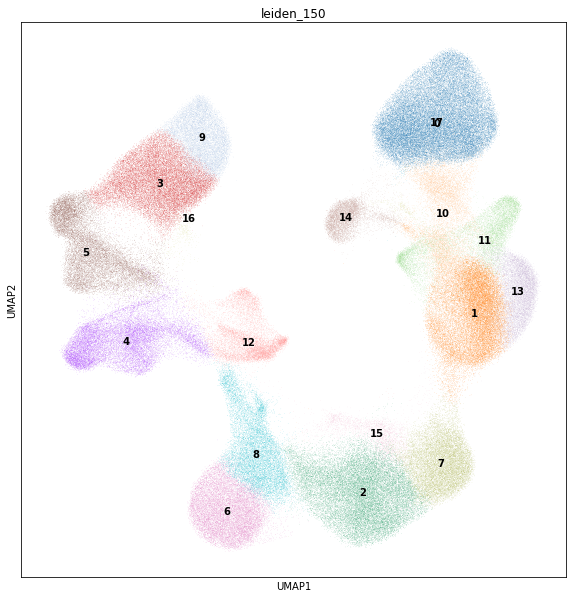

In [4]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150", "leiden_100"], legend_loc="on data")

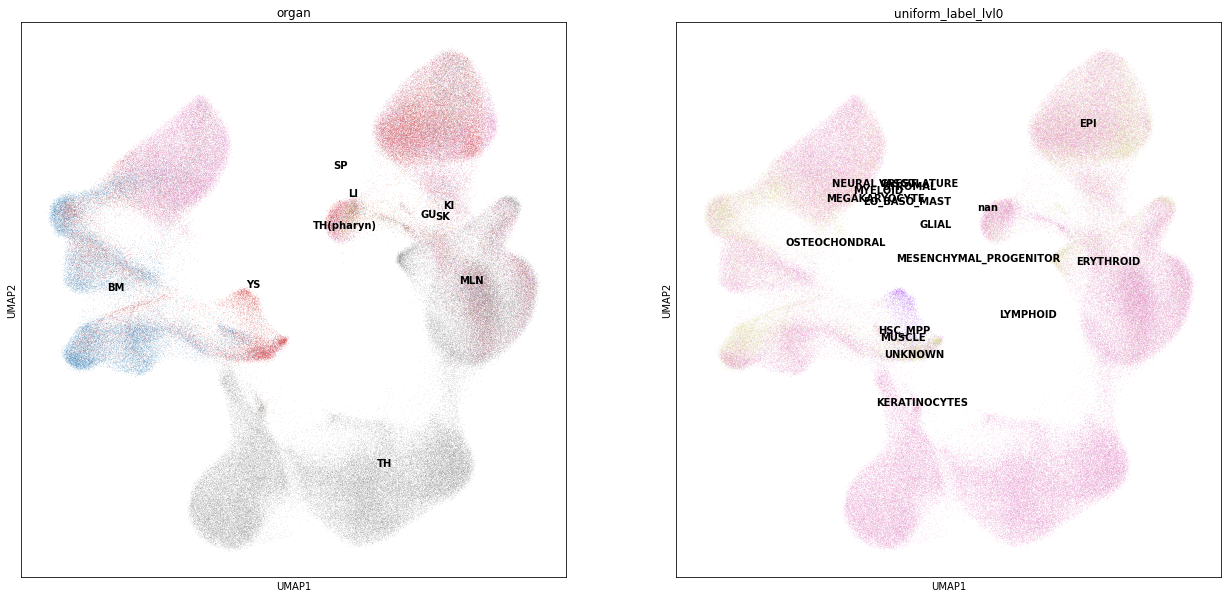

In [5]:
sc.pl.umap(adata, color=["organ", 'uniform_label_lvl0'], legend_loc="on data")

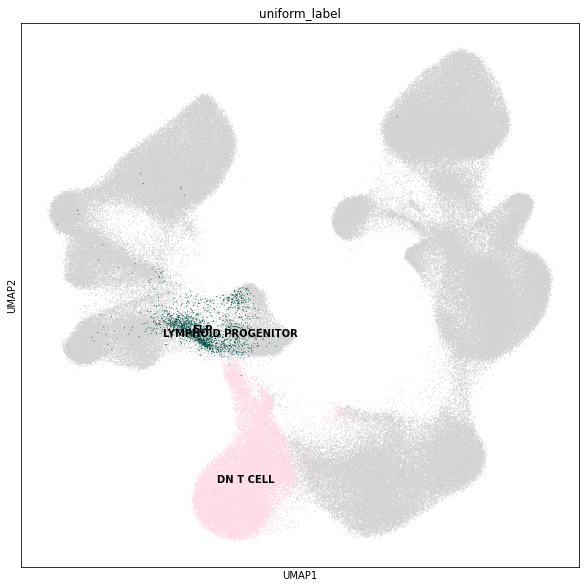

In [6]:
sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=["LYMPHOID PROGENITOR", "ELP", "DN T CELL"], size=4)

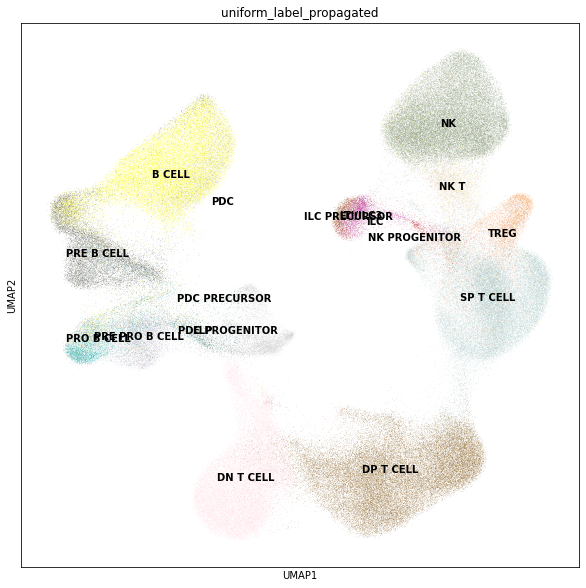

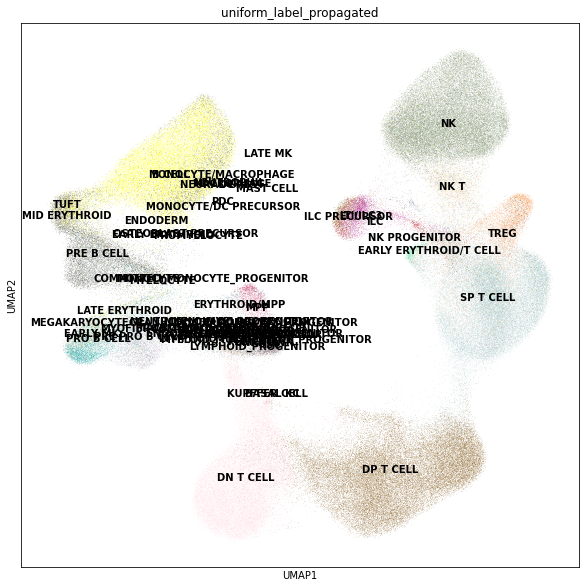

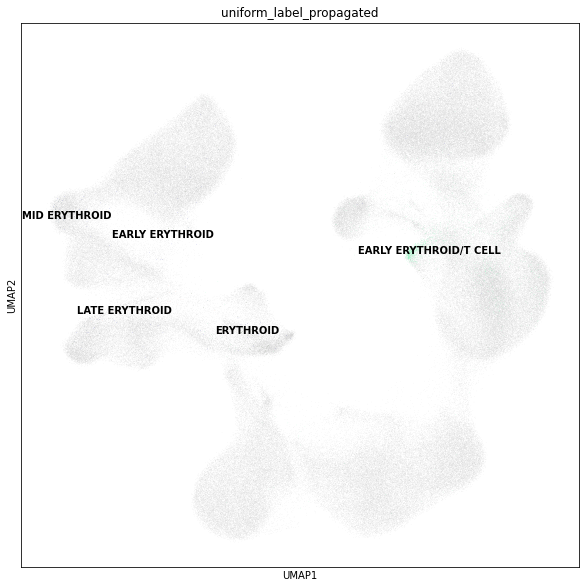

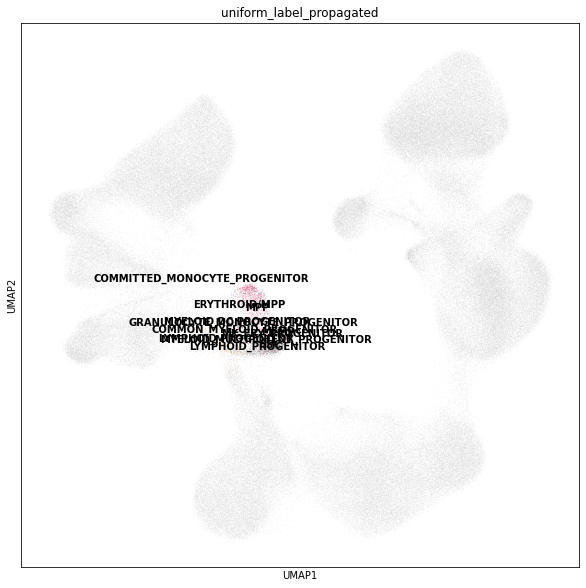

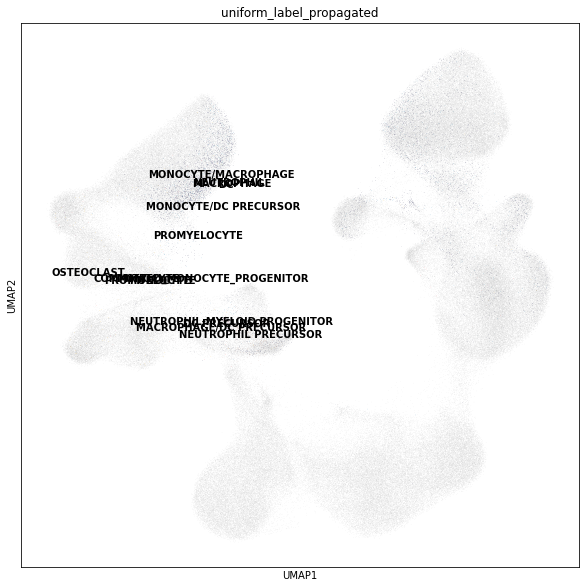

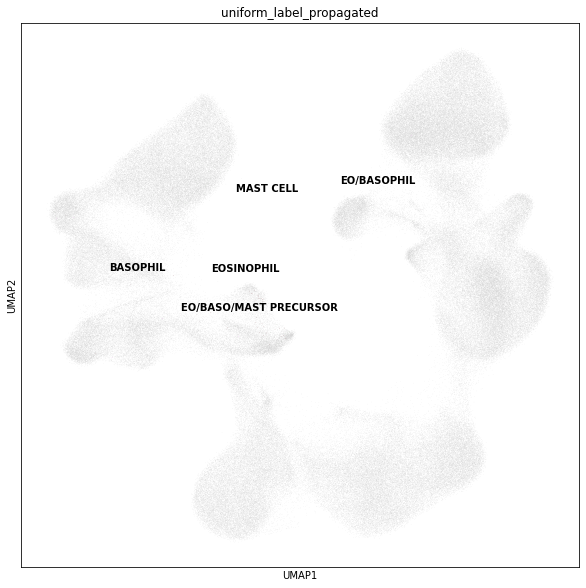

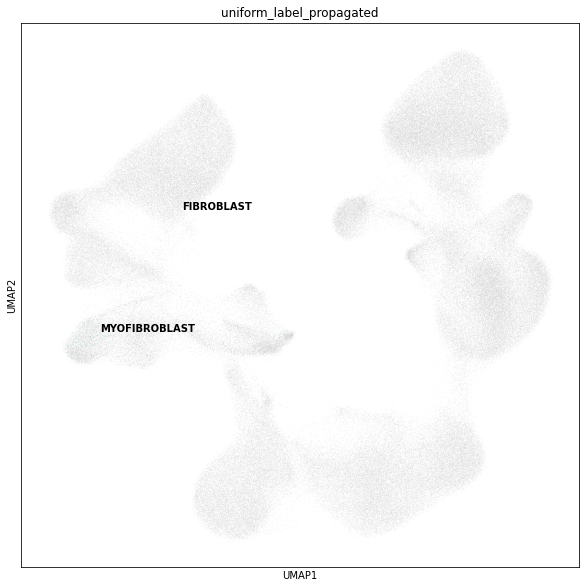

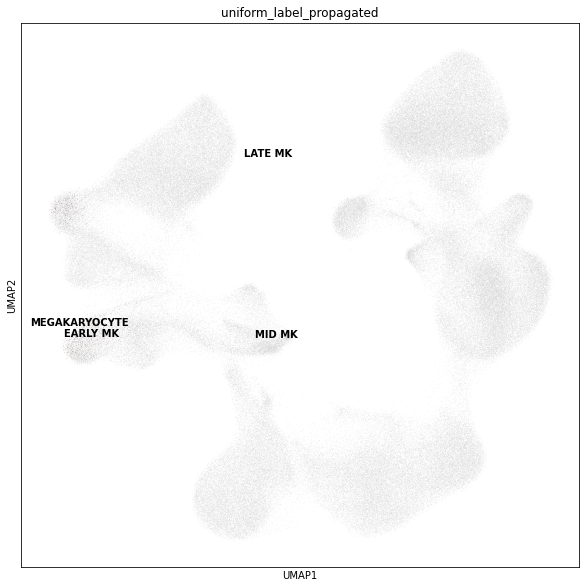

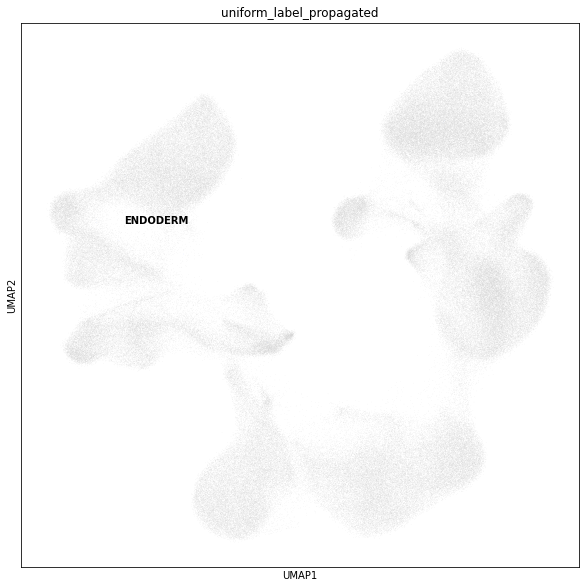

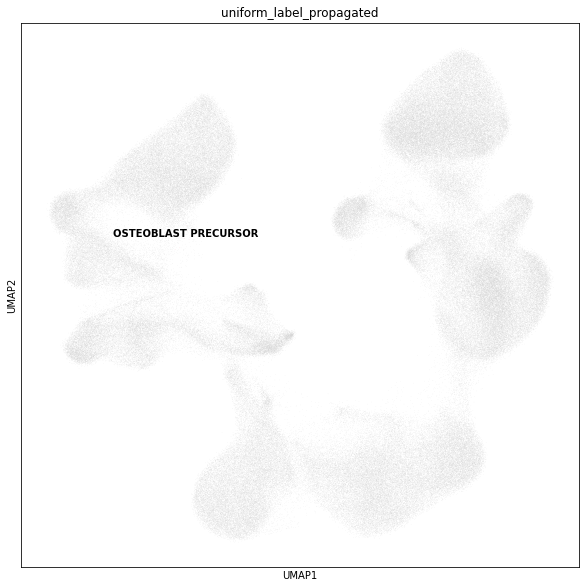

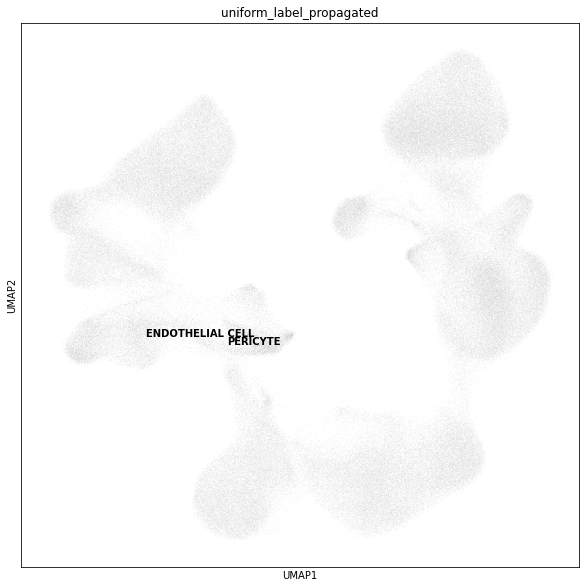

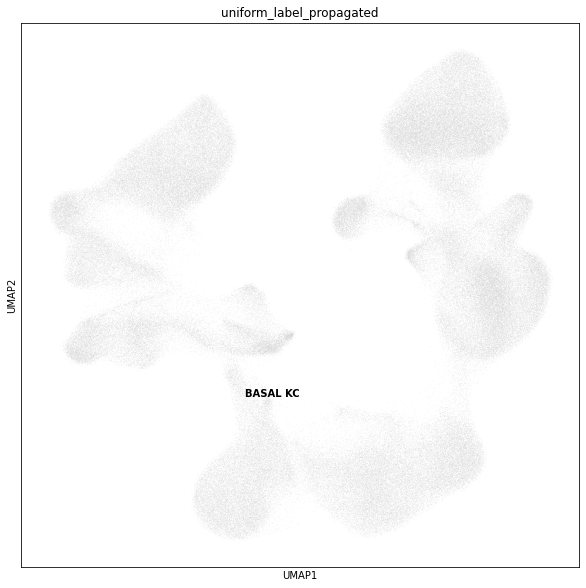

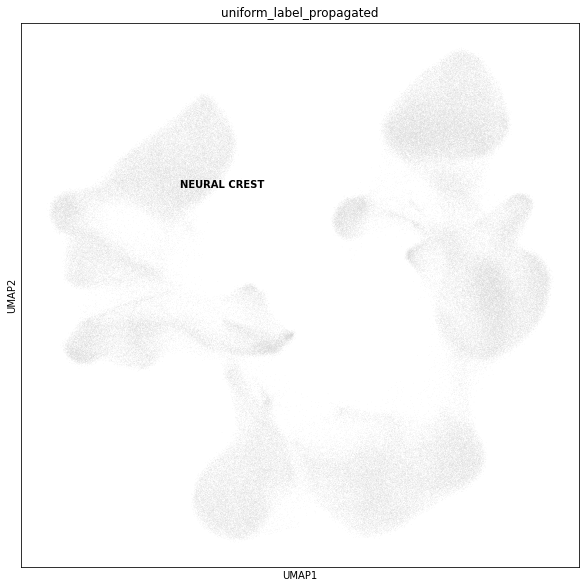

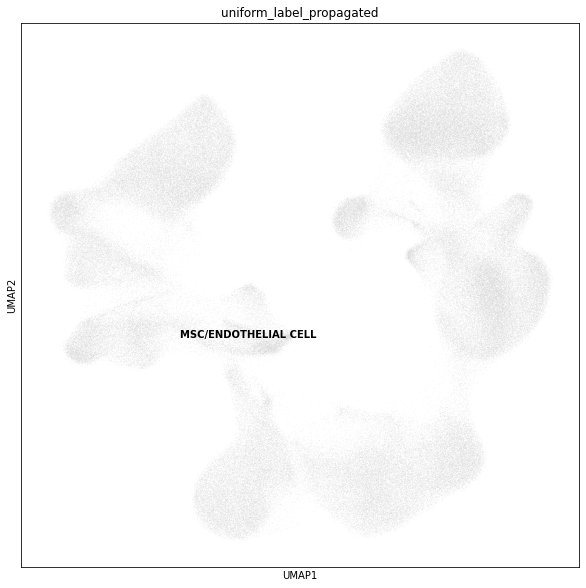

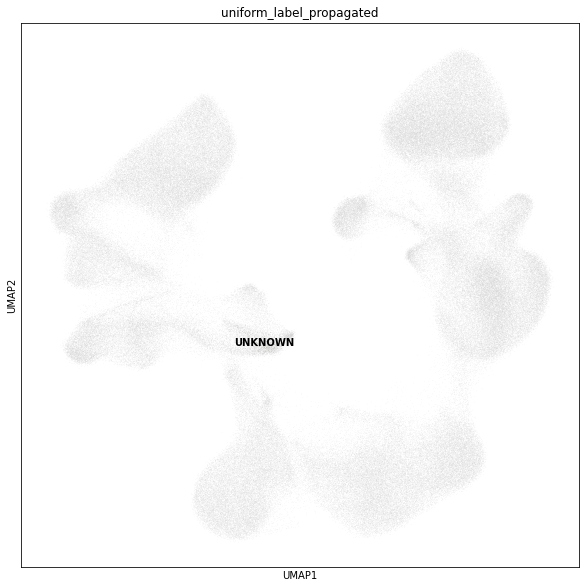

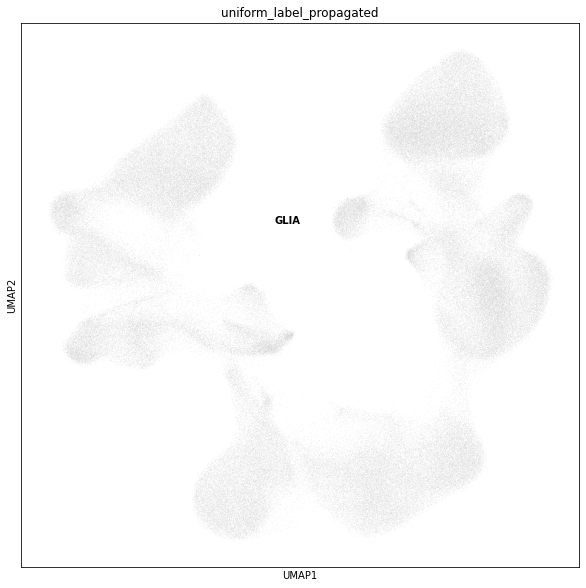

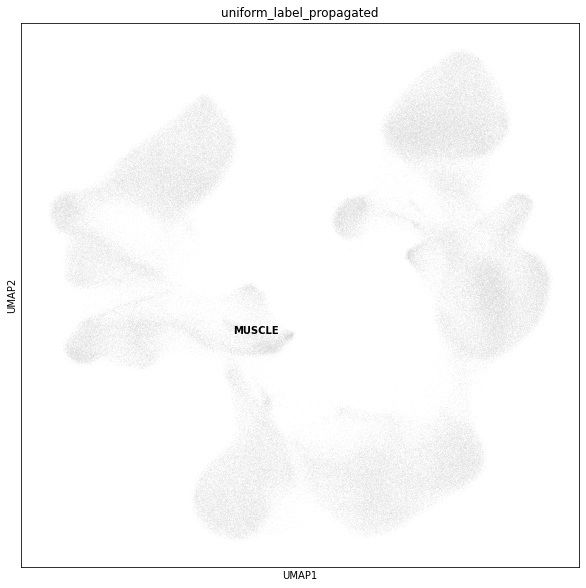

In [8]:
for o in adata.obs['uniform_label_lvl0'].unique():
    sc.pl.umap(adata, color=['uniform_label_propagated'], legend_loc="on data", 
               groups=adata.obs['uniform_label_propagated'][adata.obs['uniform_label_lvl0'] == o].unique())

### Annotate clusters using most frequent label 

In [33]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged_propagated', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged_propagated']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged_propagated'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

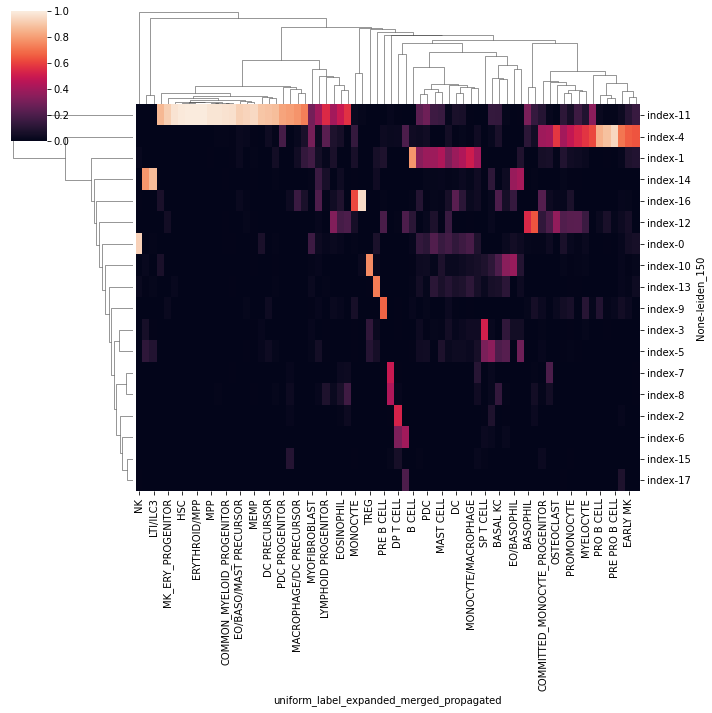

In [42]:
import seaborn as sns
sns.clustermap(cl_counts[cl_counts.index!="nan"].T/cl_counts[cl_counts.index!="nan"].sum(1))

... storing 'leiden_150_pred_label' as categorical


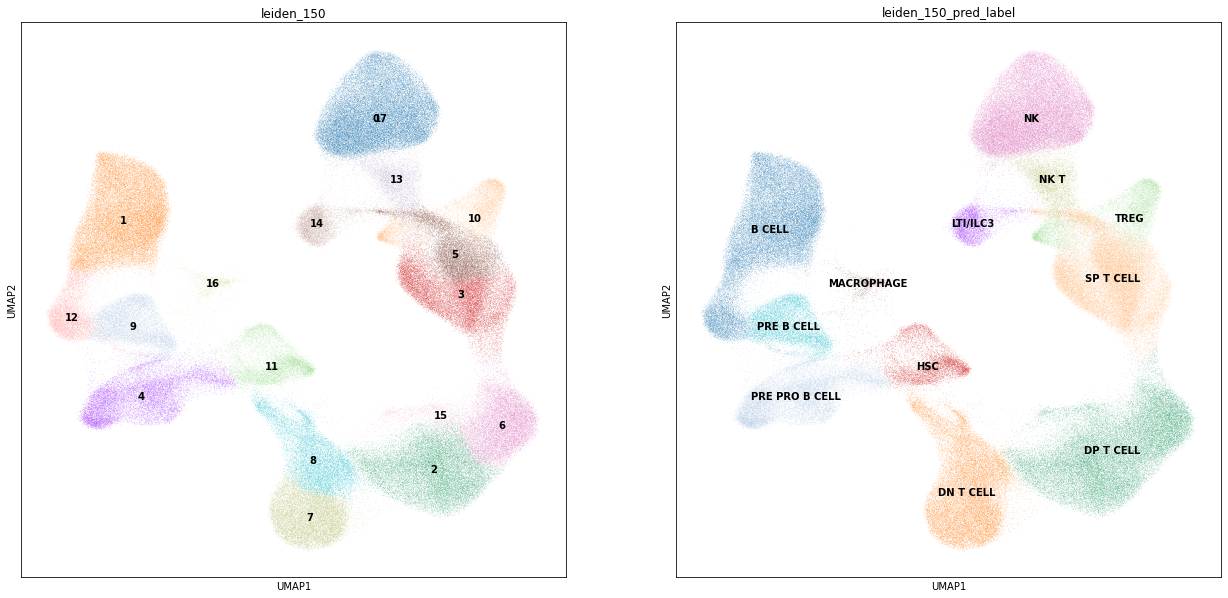

In [43]:
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")

## Split in NKT/B
Here I save B with the progenitors

In [51]:
## Define hierarchy for making data subsets
pfi_splitting_df = adata.obs[['leiden_150_pred_label']].drop_duplicates()

pfi_splitting_df["split_NKT"] = [
    "NKT" if pfi_splitting_df['leiden_150_pred_label'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "TREG", "LTI/ILC3", "HSC"] or pfi_splitting_df['leiden_150_pred_label'].loc[i]=="MPP"
    else "B" if "B CELL" in pfi_splitting_df['leiden_150_pred_label'].loc[i]  
    else "MYELOID"
    for i in pfi_splitting_df.index
]

pfi_splitting_df["split_B"] = [
    "NKT" if pfi_splitting_df['leiden_150_pred_label'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "TREG", "LTI/ILC3"]
    else "B" if "B CELL" in pfi_splitting_df['leiden_150_pred_label'].loc[i] or pfi_splitting_df['leiden_150_pred_label'].loc[i]=="HSC" 
    else "MYELOID"
    for i in pfi_splitting_df.index
]

pfi_splitting_df["split_B"] = ['B' if pfi_splitting_df["split_B"].loc[i]=="B" else np.nan for i in pfi_splitting_df.index]


pfi_splitting_df.sort_values(['split_NKT'])

leiden_150_pred_label split_NKT split_B
0           PRE PRO B CELL         B       B
2                   B CELL         B       B
3               PRE B CELL         B       B
217             MACROPHAGE   MYELOID     NaN
1                       NK       NKT     NaN
21               SP T CELL       NKT     NaN
22                     HSC       NKT       B
36                    NK T       NKT     NaN
41                    TREG       NKT     NaN
503               LTI/ILC3       NKT     NaN
3825             DN T CELL       NKT     NaN
6871             DP T CELL       NKT     NaN

In [52]:
adata.obs = adata.obs[[x for x in adata.obs.columns if "split" not in x]]
adata.obs = adata.obs.merge(pfi_splitting_df, on=['leiden_150_pred_label'], how='left', indicator=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


... storing 'split_NKT' as categorical
... storing 'split_B' as categorical


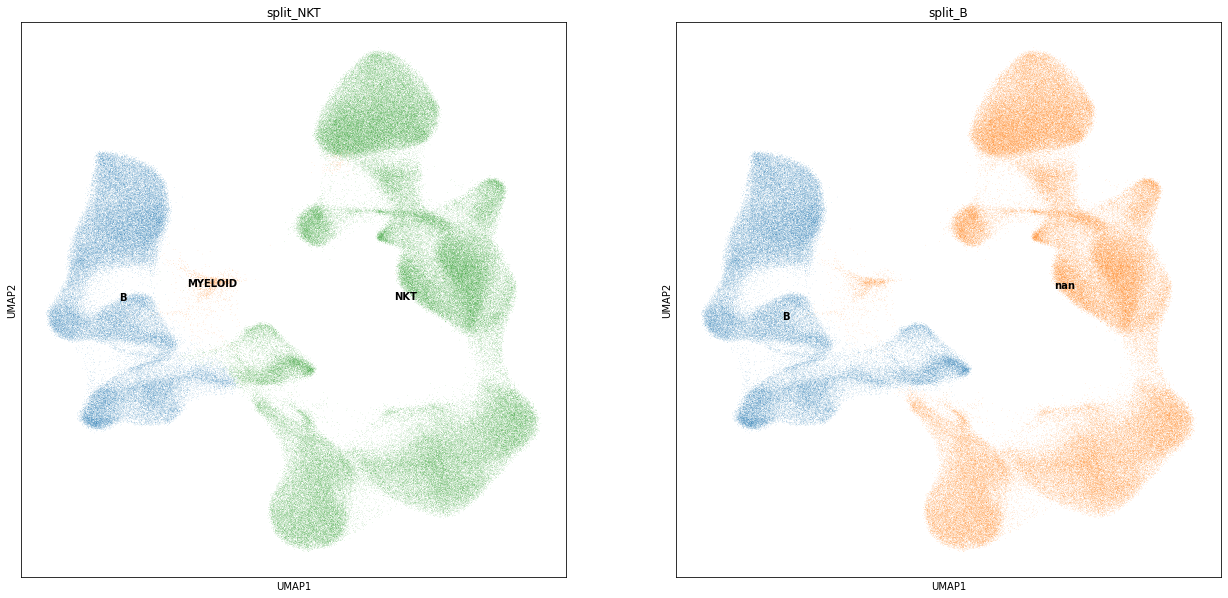

In [53]:
sc.pl.umap(adata, color=["split_NKT", 'split_B'], legend_loc="on data")

In [16]:
adata_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [54]:
adata_raw = adata_raw[adata.obs_names]

In [55]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118'

In [58]:
for s in ["B", "NKT"]:
    split_col = 'split_' + s
    adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
    sdata = adata_raw[adata.obs[split_col]==s]
    print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
    sdata.write_h5ad(adata_name)

Saving B anndata (75736 cells, 10 organs)
Saving NKT anndata (175774 cells, 10 organs)
